To open in Google Colab click here: https://colab.research.google.com/drive/1ZGrprBnEX_z8N2U7aj8icNKMSQh-JvIu?usp=sharing

# Women in AI & Robotics

## Data Analysis for Bias and Text Preprocessing

### October 2023

We are analysing a dataset of American News from 2016/2017 and checking for potential biases.


In [ ]:
# @title Install needed packages
!pip install snorkel
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 2.6 MB/s eta 0:00:00


## Install and import libraries

In [ ]:
# pandas and numpy
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from pandas import DataFrame


#import libraries and modules
from google.colab import files
import io

#import warnings
#warnings.filterwarnings('ignore')

#Snorkel
from snorkel.labeling import LabelingFunction
import re
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LFAnalysis
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.labeling import labeling_function

# API
import requests
import json

# sentiment analysis
import spacy
import nltk
from spacy.lang.en.stop_words import STOP_WORDS

# NLTK
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
import string
from string import punctuation
from nltk.corpus import stopwords

import nltk.tokenize
punc = string.punctuation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from statistics import mean
from heapq import nlargest

# miscellaneous
import time as timer
from datetime import datetime, date, time
from tqdm import tqdm
from collections import Counter
import pickle
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

#Supervised learning
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

##Deep learning libraries and APIs
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and prepare data

In [ ]:
# download the dataset from here: https://www.kaggle.com/datasets/snapcrack/all-the-news/data
# Importing the dataset
df_1 = pd.read_csv("/content/drive/MyDrive/info/articles1.csv")
df_2 = pd.read_csv("/content/drive/MyDrive/info/articles2.csv")
df_3 = pd.read_csv("/content/drive/MyDrive/info/articles3.csv")

In [ ]:
# Checking if the columns are same or not
df_1.columns == df_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
# Checking if the columns are same or not
df_2.columns == df_3.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
# Making one Dataframe by appending all of them for the further process
d = [df_1, df_2, df_3]
df = pd.concat(d, keys = ['x', 'y', 'z'])
df.rename(columns = {'content' : 'article'}, inplace = True);

In [ ]:
df.head()

Unnamed: 0     id                                              title  \
x 0           0  17283  House Republicans Fret About Winning Their Hea...   
  1           1  17284  Rift Between Officers and Residents as Killing...   
  2           2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
  3           3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
  4           4  17287  Kim Jong-un Says North Korea Is Preparing to T...   

        publication                         author        date    year  month  \
x 0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
  1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
  2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
  3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
  4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

     url                                            article  
x 0  NaN  WASHINGTON  —   Congressional Republicans have...  
  1  NaN  After the bullet shells get counted, the blood...  
  2  NaN  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  NaN  Death may be the great equalizer, but it isn’t...  
  4  NaN  SEOUL, South Korea  —   North Korea’s leader, ...

In [ ]:
# Shape of the dataset
print ("The shape of the dataset : ", df.shape)

The shape of the dataset :  (142570, 10)


In [ ]:
# Dropping the unnecessary columns
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

id                                              title     publication  \
x 0  17283  House Republicans Fret About Winning Their Hea...  New York Times   
  1  17284  Rift Between Officers and Residents as Killing...  New York Times   
  2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...  New York Times   
  3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...  New York Times   
  4  17287  Kim Jong-un Says North Korea Is Preparing to T...  New York Times   

                            author        date    year  month  url  \
x 0                     Carl Hulse  2016-12-31  2016.0   12.0  NaN   
  1  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0  NaN   
  2                   Margalit Fox  2017-01-06  2017.0    1.0  NaN   
  3               William McDonald  2017-04-10  2017.0    4.0  NaN   
  4                  Choe Sang-Hun  2017-01-02  2017.0    1.0  NaN   

                                               article  
x 0  WASHINGTON  —   Congressional Republicans have...  
  1  After the bullet shells get counted, the blood...  
  2  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  Death may be the great equalizer, but it isn’t...  
  4  SEOUL, South Korea  —   North Korea’s leader, ...

[Text(0.5, 0, 'Publication'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of Publications')]

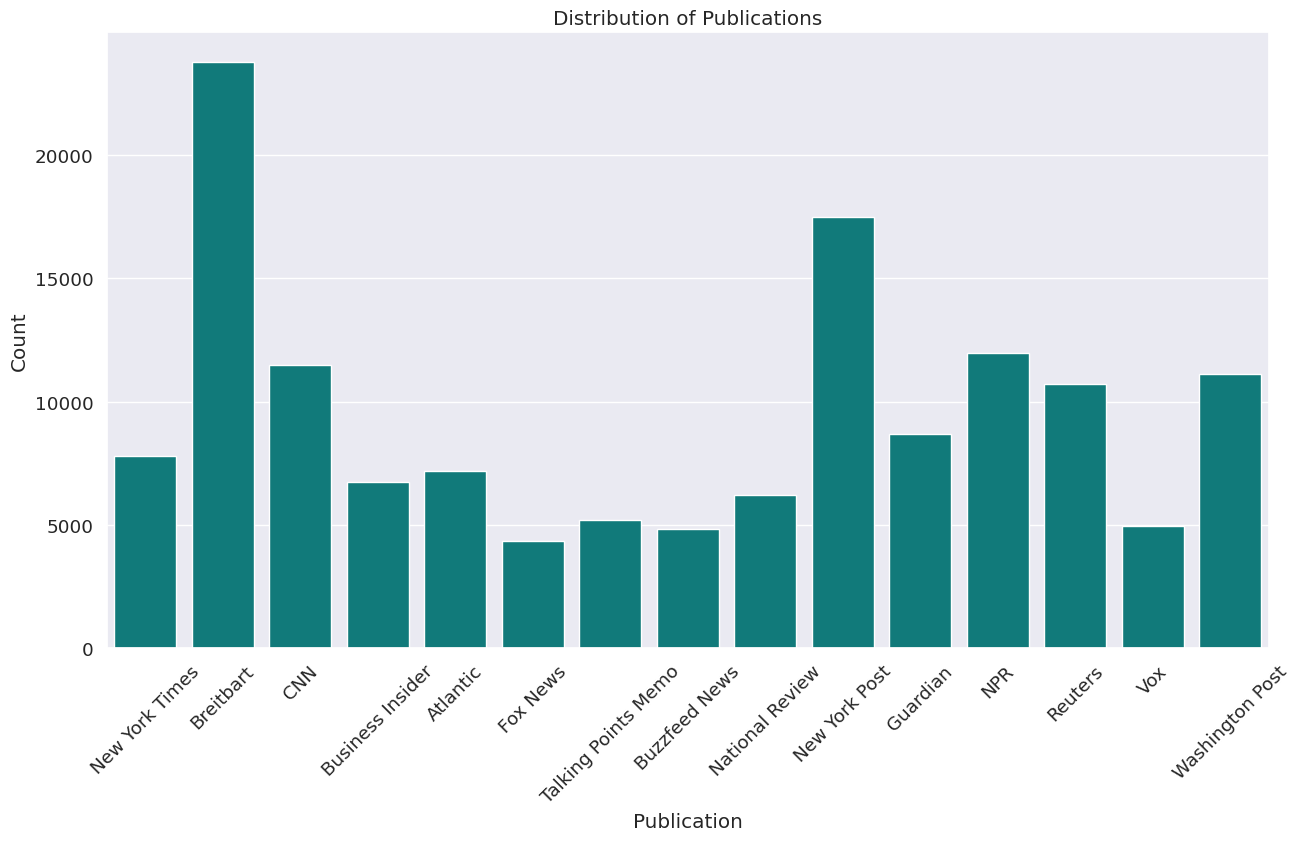

In [ ]:
# Countplot shows the distribution of Publication
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'darkgrid')
sns_year = sns.countplot(x=df['publication'], color = 'darkcyan')
plt.xticks(rotation=45)
sns_year.set(xlabel = "Publication", ylabel = "Count", title = "Distribution of Publications")

In [ ]:
# Years
df['year'].value_counts()

2016.0    85405
2017.0    50404
2015.0     3705
2013.0      228
2014.0      125
2012.0       34
2011.0        8
2010.0        6
2008.0        3
2009.0        3
2004.0        2
2003.0        2
2005.0        2
2007.0        1
2000.0        1
Name: year, dtype: int64

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of the articles according to the year')]

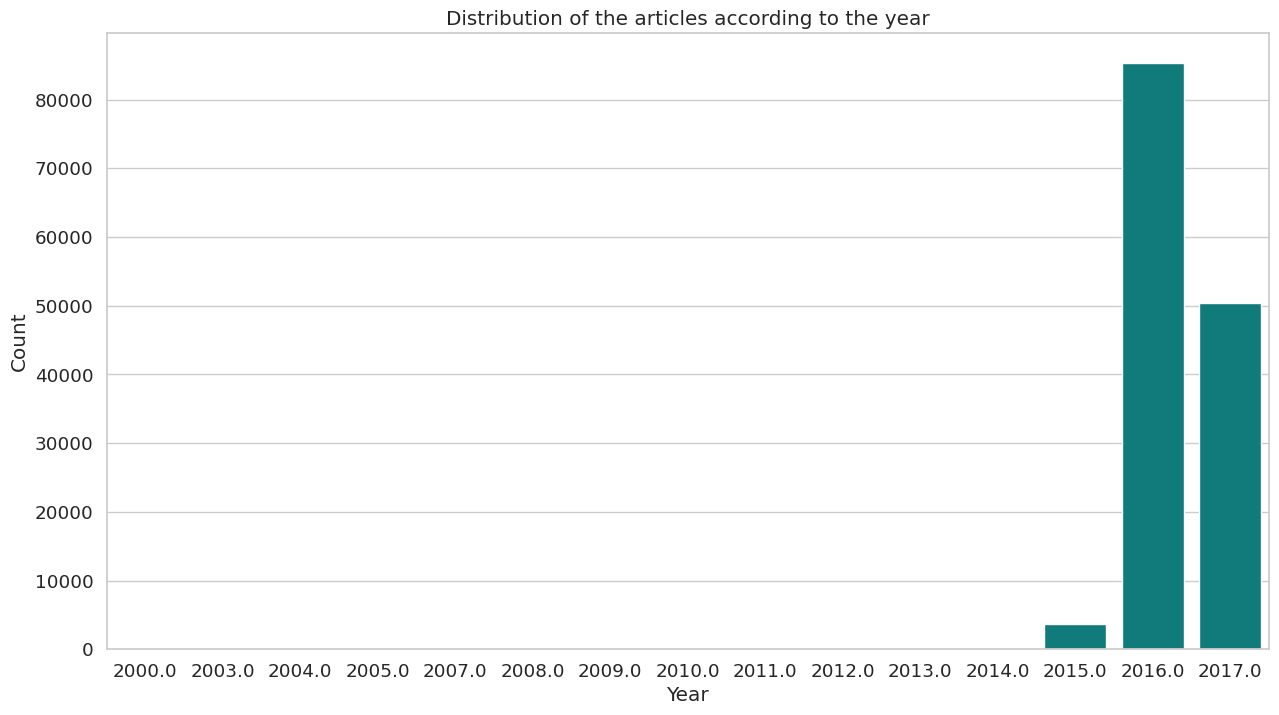

In [ ]:
# Countplot shows the distribution of the articles according to the year
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'whitegrid')
sns_year = sns.countplot(x=df['year'], color = 'darkcyan')
sns_year.set(xlabel = "Year", ylabel = "Count", title = "Distribution of the articles according to the year")

In [ ]:
# Authors
df['author'].value_counts()

Breitbart News                                         1559
Pam Key                                                1282
Associated Press                                       1231
Charlie Spiering                                        928
Jerome Hudson                                           806
                                                       ... 
Laura Italiano, Sophia Rosenbaum and Philip Messing       1
Larry Celona, C.J. Sullivan and Daniel Prendergast        1
Krit McClean                                              1
Melissa Klein and Joe Tacopino                            1
John Yearwood                                             1
Name: author, Length: 15647, dtype: int64

[Text(0.5, 29.0, 'count'),
 Text(29.0, 0.5, 'author'),
 Text(0.5, 1.0, 'the most freq author')]

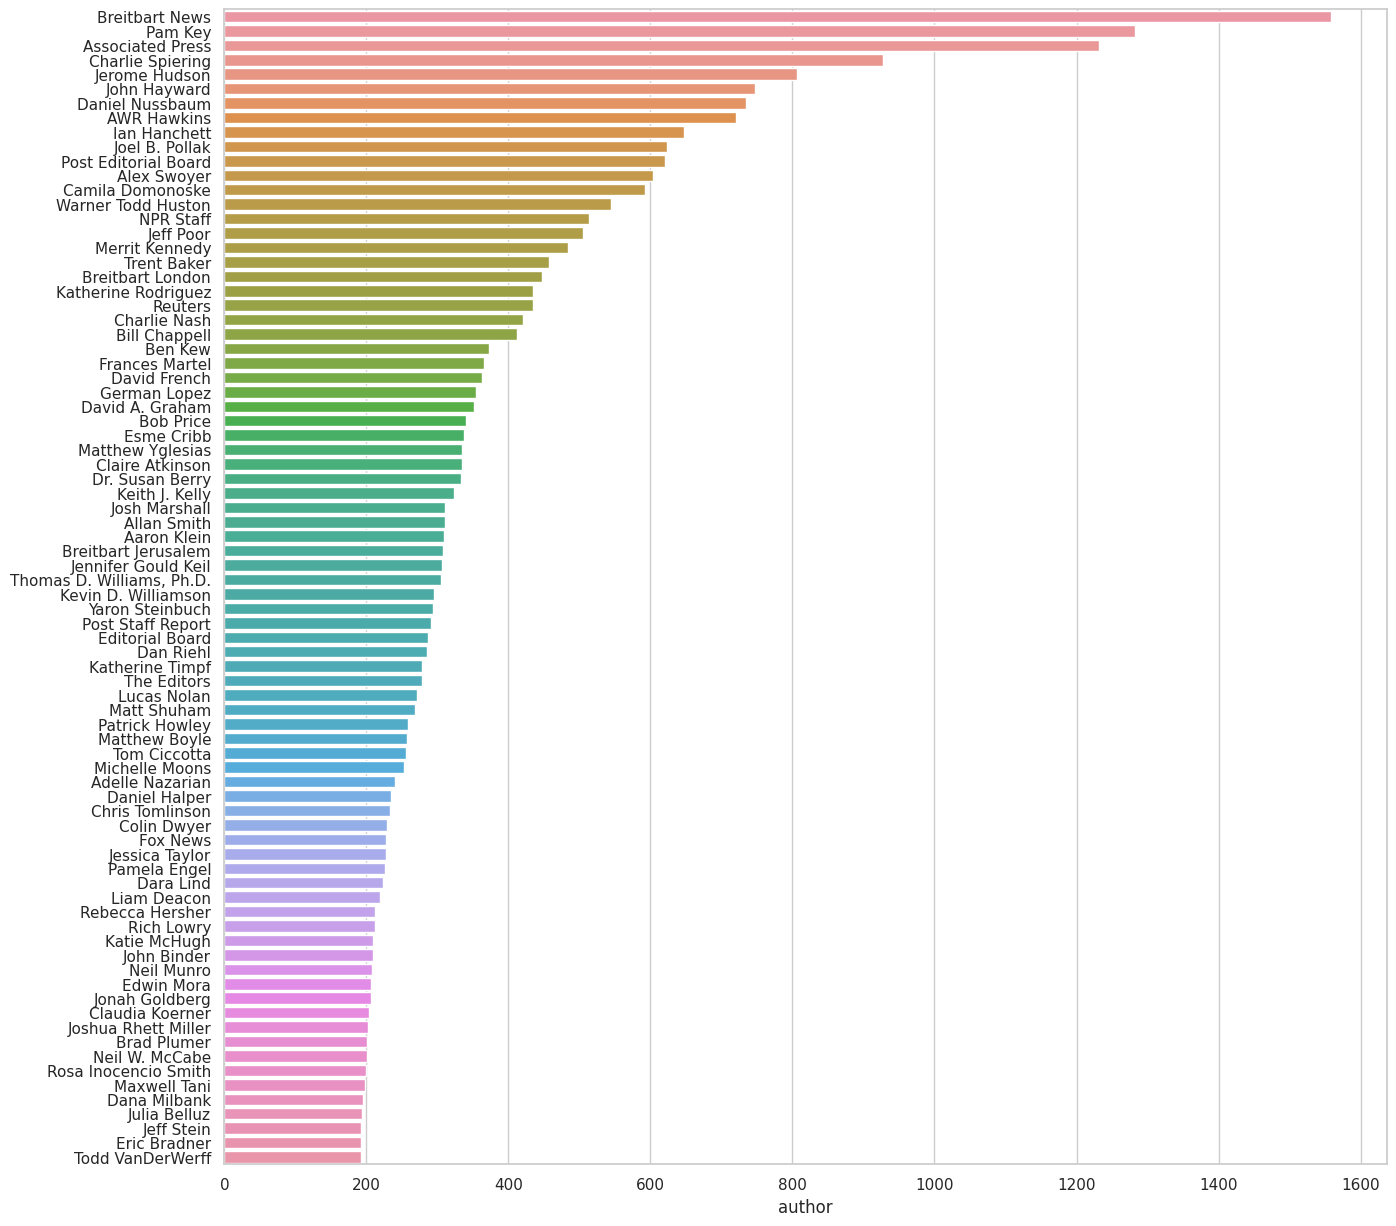

In [ ]:
# Countplot shows the distribution of author
plt.rcParams['figure.figsize'] = [15, 15]
sns.set(font_scale = 1, style = 'whitegrid')
df_author = df.author.value_counts().head(80)

sns.barplot(x=df_author, y=df_author.index)
sns_year.set(xlabel = "count", ylabel = "author", title = "the most freq author")

In [ ]:
# Making one Dataframe by appending all of them for the further process
d = [df_1, df_2, df_3]
df = pd.concat(d, keys = ['x', 'y', 'z'])
df.rename(columns = {'content' : 'article'}, inplace = True);

In [ ]:
df.head()

Unnamed: 0     id                                              title  \
x 0           0  17283  House Republicans Fret About Winning Their Hea...   
  1           1  17284  Rift Between Officers and Residents as Killing...   
  2           2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
  3           3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
  4           4  17287  Kim Jong-un Says North Korea Is Preparing to T...   

        publication                         author        date    year  month  \
x 0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
  1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
  2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
  3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
  4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

     url                                            article  
x 0  NaN  WASHINGTON  —   Congressional Republicans have...  
  1  NaN  After the bullet shells get counted, the blood...  
  2  NaN  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  NaN  Death may be the great equalizer, but it isn’t...  
  4  NaN  SEOUL, South Korea  —   North Korea’s leader, ...

In [ ]:
# Dropping the unnecessary columns
df.drop(columns = ['Unnamed: 0', 'id', 'publication', 'author', 'date', 'year', 'month', 'url'], inplace = True)
df.head()

title  \
x 0  House Republicans Fret About Winning Their Hea...   
  1  Rift Between Officers and Residents as Killing...   
  2  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
  3  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
  4  Kim Jong-un Says North Korea Is Preparing to T...   

                                               article  
x 0  WASHINGTON  —   Congressional Republicans have...  
  1  After the bullet shells get counted, the blood...  
  2  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  Death may be the great equalizer, but it isn’t...  
  4  SEOUL, South Korea  —   North Korea’s leader, ...

In [ ]:
df['title'] = df['title'].astype(str)
df['article'] = df['article'].astype(str)
#check the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 142570 entries, ('x', 0) to ('z', 42570)
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   title    142570 non-null  object
 1   article  142570 non-null  object
dtypes: object(2)
memory usage: 4.2+ MB


In [ ]:
df_article = df[['article']].copy()
df_title = df[['title']].copy()

df_title.head()

title
x 0  House Republicans Fret About Winning Their Hea...
  1  Rift Between Officers and Residents as Killing...
  2  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...
  3  Among Deaths in 2016, a Heavy Toll in Pop Musi...
  4  Kim Jong-un Says North Korea Is Preparing to T...

In [ ]:
df_article.head()

article
x 0  WASHINGTON  —   Congressional Republicans have...
  1  After the bullet shells get counted, the blood...
  2  When Walt Disney’s “Bambi” opened in 1942, cri...
  3  Death may be the great equalizer, but it isn’t...
  4  SEOUL, South Korea  —   North Korea’s leader, ...

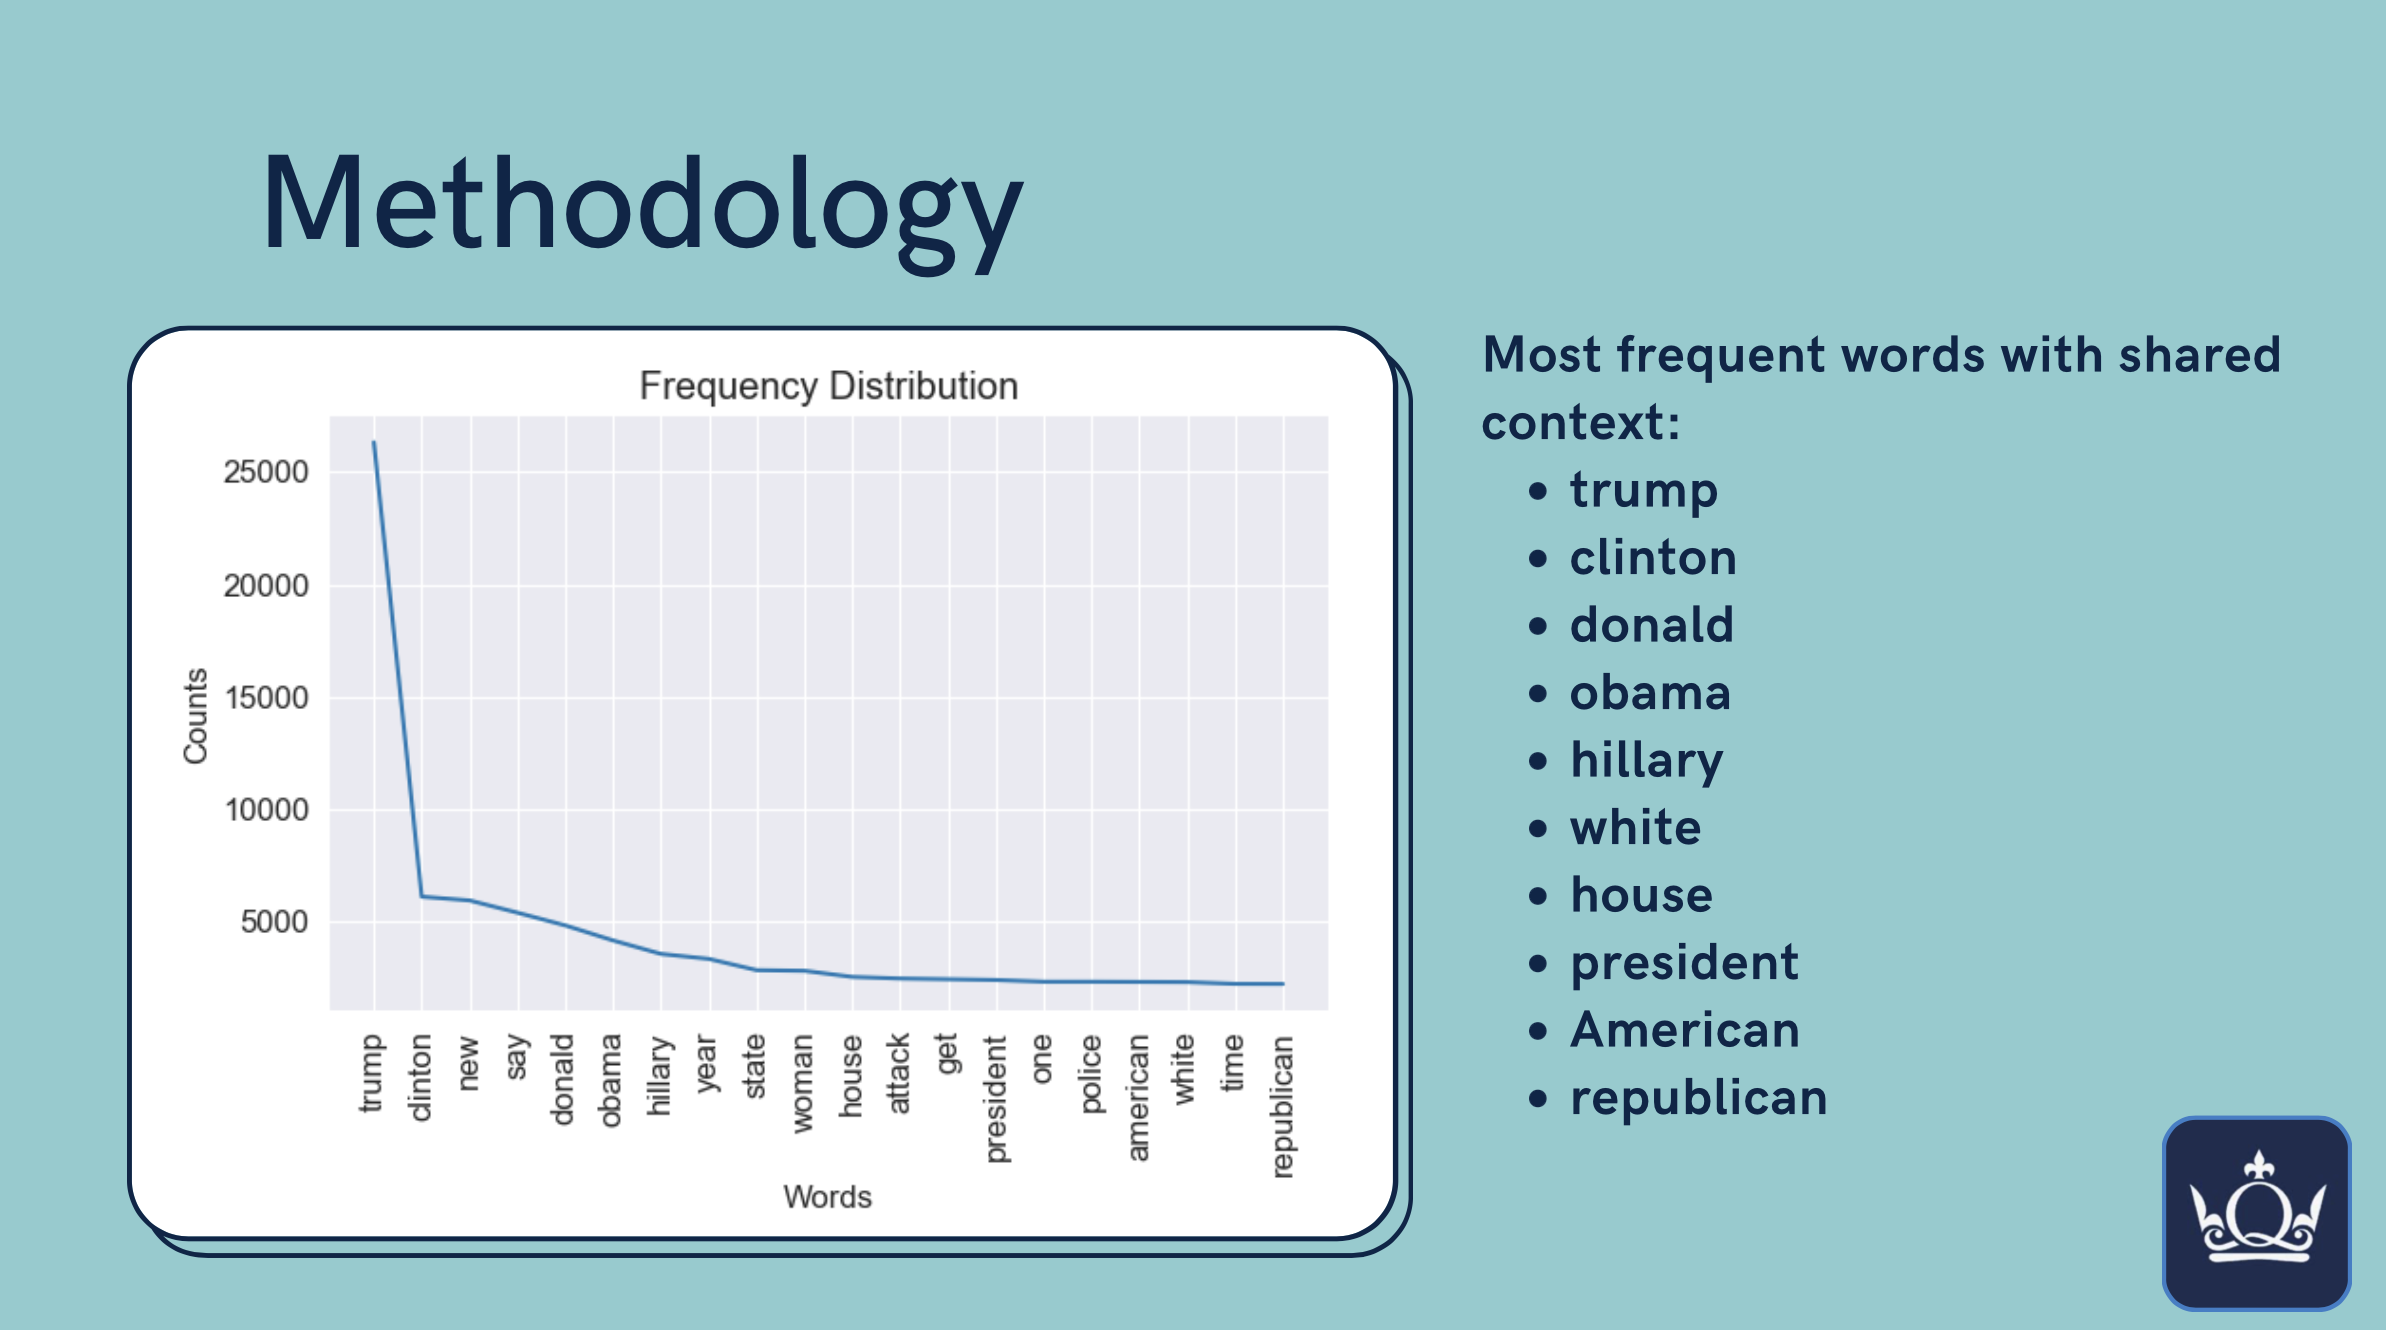

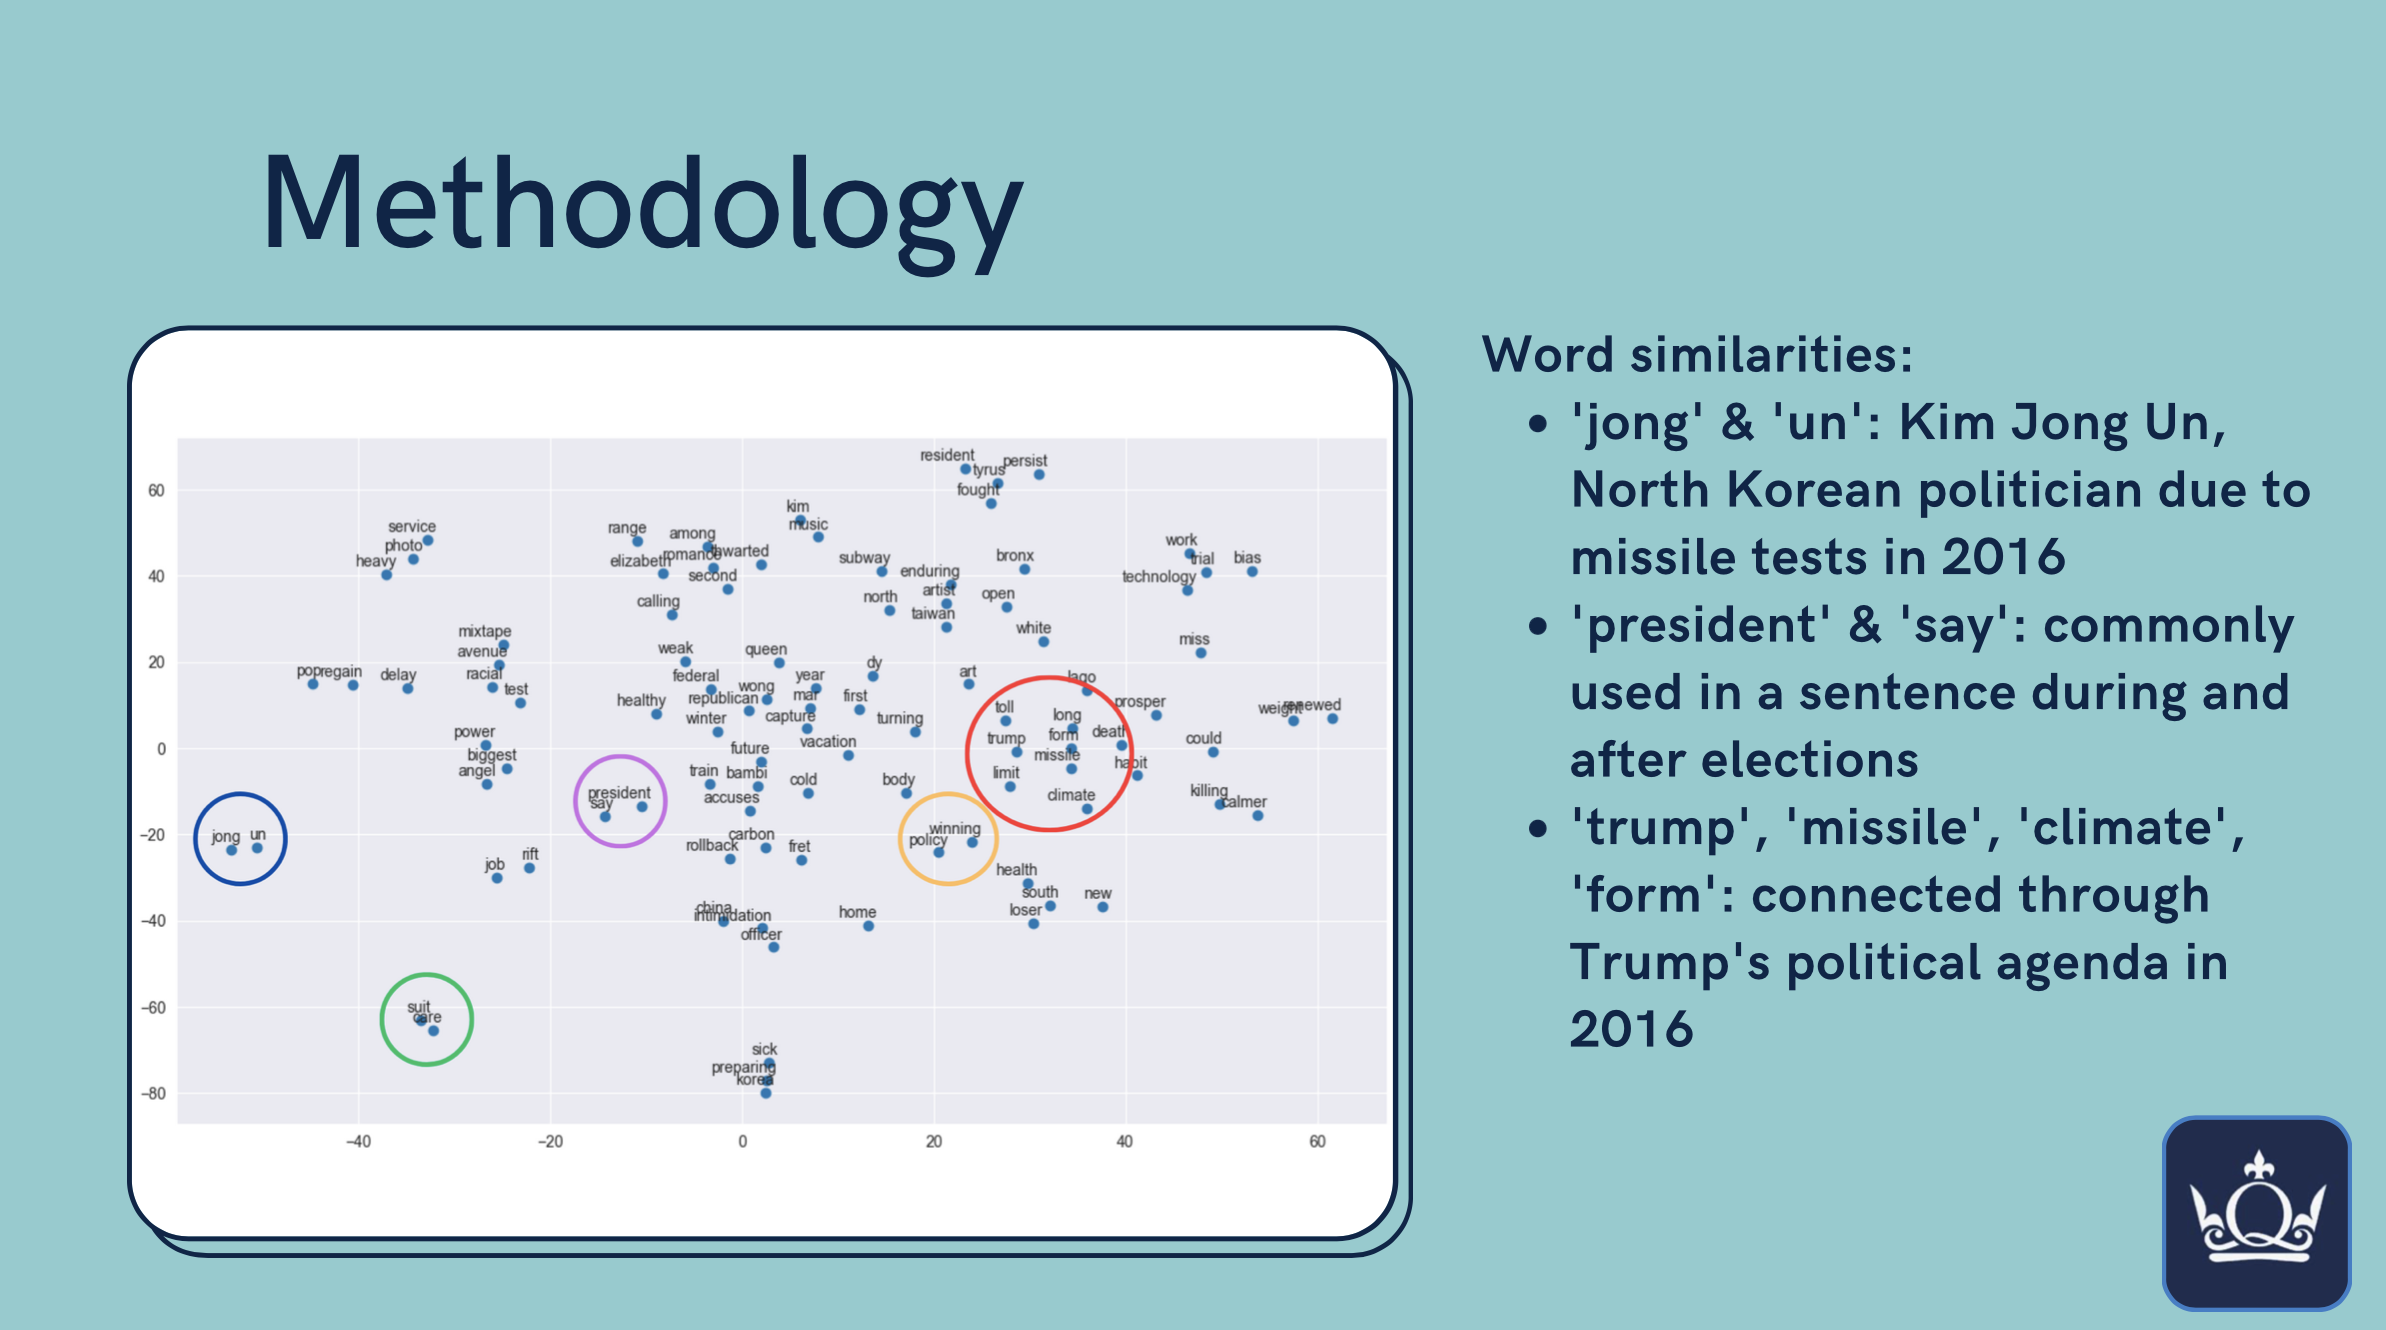

# Text Processing

In [ ]:
title_tt = df_title.copy()
article_tt = df_article.copy()

In [ ]:
from nltk.stem import WordNetLemmatizer  # lemmatization
import nltk
nltk.download('wordnet')

def pre_process(text):

    # take care of punction
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # when at the beginning of a string, separate punctuation
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # when at the end of a string, separate punctuation

    # remove any numbers
    numbers = r'\d+'
    text = re.sub(pattern=numbers, repl=" ", string=text)

    # split the string into separate tokens
    tokens = re.split(r"\s+",text)


    # normalise all words into lowercase
    final = [t.lower() for t in tokens]


    tokens = []

    # remove any strings signalising end of line
    for i in range(len(final)):
        if final[i] != '_eol_':
            tokens.append(final[i])

    # remove any unncessary punctuation connected to words
    x = '[{}]'.format(re.escape(string.punctuation)+'\…').replace("...", "").replace("\-", "")
    pattern = re.compile(x)
    tokens = [f for f in filter(None, [pattern.sub('', token) for token in tokens])]

    # remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords]

    # apply lemmatisation
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(token) for token in tokens]


    # return final list of tokens
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# TEST
#text_test = "I have the high ground, Anakin!"
text_test = "I have e ' h , the — high ground ” , “ Anakin! - The New York Times"
tokens_test = pre_process(text_test)
print(tokens_test)

['e', 'h', '—', 'high', 'ground', '”', '“', 'anakin', '-', 'new', 'york', 'time']


In [ ]:
from nltk.stem import WordNetLemmatizer  # lemmatization
import nltk
nltk.download('wordnet')

def pre_process(df):

    publishers = ['The New York Times', 'Breitbart', 'CNN', 'Business Insider', 'Fox News', 'Talking Points Memo', 'Buzzfeed News', 'National Review', 'New York Post', 'The Guardian', 'NPR', 'Reuters', 'Vox', 'Washington Post', 'Associated Press']

    text = df

    for a in publishers:
      if a in df:
        text = df.replace(a, '')

    # take care of punction
    text = re.sub(r"([.,;‘:’!-?'\"“\(\)])(\w)", r"\1 \2", text) # when at the beginning of a string, separate punctuation
    text = re.sub(r"(\w)([.,;‘:’!-?'\"”\)])", r"\1 \2", text) # when at the end of a string, separate punctuation

    # remove any numbers
    numbers = r'\d+'
    text = re.sub(pattern=numbers, repl=" ", string=text)

    # split the string into separate tokens
    tokens = re.split(r"\s+",text)

    # normalise all words into lowercase
    final = [t.lower() for t in tokens]

    tokens = []

    # remove any strings signalising end of line
    for i in range(len(final)):
      if final[i] != '-' and final[i] != '—' and final[i] != '“' and final[i] != '”':
        tokens.append(final[i])

    # remove any unncessary punctuation connected to words
    x = '[{}]'.format(re.escape(string.punctuation)+'…').replace("...", "").replace("-", "").replace("‘", "").replace("’", "")
    pattern = re.compile(x)
    tokens = [f for f in filter(None, [pattern.sub('', token) for token in tokens])]

    # remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords]

    # apply lemmatisation
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(token) for token in tokens]

    tokens = [w for w in tokens if len(w)>1]

    # return final list of tokens
    return tokens


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# TEST
#text_test = "I have the high ground, Anakin!"
text_test = "I have e ' h , the — high ground ” , “ Anakin! - The New York Times"
tokens_test = pre_process(text_test)
print(tokens_test)

['high', 'ground', 'anakin']


In [ ]:
# create a new column for the tokenised text
tokenised = ['']*142570
title_tt['tokenised'] = tokenised

for index, row in title_tt.iterrows():
  token = []
  token = pre_process(row['title'])

  # Using .join() to Convert a List to a String
  conv_token = ' '.join(token)

  title_tt.loc[index, 'tokenised'] = conv_token

title_tt.head()

title  \
x 0  House Republicans Fret About Winning Their Hea...   
  1  Rift Between Officers and Residents as Killing...   
  2  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
  3  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
  4  Kim Jong-un Says North Korea Is Preparing to T...   

                                             tokenised  
x 0     house republican fret winning health care suit  
  1  rift officer resident killing persist south bronx  
  2    tyrus wong bambi artist thwarted racial bias dy  
  3                   among death heavy toll pop music  
  4  kim jong un say north korea preparing test lon...

# Skipgram

In [ ]:
from keras.preprocessing.sequence import skipgrams
from keras.layers import Dot, Embedding, Input
from keras.layers import Dense, Reshape
from keras.models import Model
from keras.utils import plot_model

from IPython.display import SVG, display
#from keras.utils import vis_utils
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import collections

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from datetime import datetime
# good tutorial: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/


In [ ]:
# return the dictionary with all the unique words in the dataset
def prepare_data(text):

		# create a temporary list that includes all words
		word_list = []
		text = text['tokenised']

		# create the empty dictionary
		word2idx = dict()

		# iterate through the entire corpus to create the list of words
		for row in text:

			row = row.split()

			for word in row:

				if word not in word_list:
					word_list.append(word)

		# iterate through the list of words and add each word with the corresponding index to the dictionary
		for idx, word in enumerate(word_list):
			word2idx[word] = idx

		# return the final dictionary
		return word2idx

In [ ]:
def get_idx2word(word2idx):

		idx2word = {index: word for word, index in word2idx.items()}

		return idx2word

In [ ]:
def get_words(text):

		# create a temporary list that includes all words
		word_list = []
		text = text['tokenised']

		# iterate through the entire corpus to create the list of words
		for row in text:

			row = row.split()

			for word in row:

				word_list.append(word)

		return word_list

In [ ]:
# plot the word frequency of the top 20 most frequently used words
def plot_freq(text):

		wordl = get_words(text)
		counter = collections.Counter(wordl)

		sns.set_style('darkgrid')
		words = nltk.FreqDist(wordl)
		ll = dict(sorted(counter.items(),key=lambda x:x[1], reverse=True))
		lls = ll.items()
		x,y = zip(*lls)

		plt.close()

		plt.plot(x[:20],y[:20])
		plt.title('Frequency Distribution')
		plt.xlabel('Words')
		plt.xticks(x[:20], rotation=90)
		plt.ylabel('Counts')
		plt.tight_layout()

		#plt.savefig("../plots/plot_freq_" + datetime.now().strftime("%Y%m%d-%H%M"))
		#self.write_report("![](../plots/plot_freq_" + datetime.now().strftime("%Y%m%d-%H%M")+ ".png)")

		return counter

In [ ]:
# plot the word similarities in a t-SNE plot
def plot_tsne(word_embeddings, idx2word):

		tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
		np.set_printoptions(suppress=True)
		plot_only = 100

		T = tsne.fit_transform(word_embeddings[plot_only:(plot_only*2), :])
		labels = [idx2word[i+1] for i in range(plot_only)]
		plt.figure(figsize=(14, 8))
		plt.scatter(T[:, 0], T[:, 1])
		for label, x, y in zip(labels, T[:, 0], T[:, 1]):
			plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')

In [ ]:
def prepare_sent(text, word2idx):

		# create new list
		sents_as_ids = []
		text = text['tokenised']

		# iterate through entire corpus
		#for index, row in text.items():
		for row in text:

			#print(row)
			row = row.split()
			# create temporary list for the integers
			integer_list = []

			# iterate through all words in the sentence
			for word in row:

				# add the index of the word to the list of integers
				integer_list.append(word2idx[word])

			# add the list of integers to the final list
			sents_as_ids.append(integer_list)

		return sents_as_ids

In [ ]:
title_tt.head()

title  \
x 0  House Republicans Fret About Winning Their Hea...   
  1  Rift Between Officers and Residents as Killing...   
  2  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
  3  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
  4  Kim Jong-un Says North Korea Is Preparing to T...   

                                             tokenised  
x 0     house republican fret winning health care suit  
  1  rift officer resident killing persist south bronx  
  2    tyrus wong bambi artist thwarted racial bias dy  
  3                   among death heavy toll pop music  
  4  kim jong un say north korea preparing test lon...

In [ ]:
def train_skip(data):

		word2idx = prepare_data(data)
		idx2word = get_idx2word(word2idx)

		plot_freq(data)

		print('Number of unique words:', len(word2idx))
		print('\nSample word2idx: ', list(word2idx.items())[:10])
		print('\nSample idx2word:', list(idx2word.items())[:10])
		print('\nSample sents_as_id:', prepare_sent(data[:10], word2idx))

		VOCAB_SIZE = len(word2idx)
		EMBED_SIZE = 100 # We are creating 100D embeddings.

		skip_grams = []

		for sequence in prepare_sent(data, word2idx):

			skip_grams.append(skipgrams(sequence, VOCAB_SIZE, shuffle=False))

		pairs, labels = skip_grams[0][0], skip_grams[0][1]

		# The input is an array of target indices
		target_word = Input((1,), dtype='int32')

		# create the embedding layer
		target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
									embeddings_initializer='glorot_uniform',
									input_length=1)(target_word)

		# at this point, the input would of the shape (num_inputs x 1 x embed_size), thus, flatten
		target_input = Reshape((EMBED_SIZE, ))(target_embedding)

		# The input is an array of target indices
		context_word = Input((1,), dtype='int32')

		# create another embedding layer
		context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
									embeddings_initializer='glorot_uniform',
									input_length=1)(context_word)

		# flatten again
		context_input = Reshape((EMBED_SIZE, ))(context_embedding)
		merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])
		label = Dense(1, 'sigmoid')(merged_inputs)

		# label is the output of the above model
		model = Model(inputs=[target_word, context_word], outputs=[label])

		model.compile(loss='mean_squared_error', optimizer='adam')

		model.summary()

		NUM_EPOCHS = 3

		for epoch in range(0, NUM_EPOCHS):

			epoch_loss = 0

			for i, sent_examples in enumerate(skip_grams):

				target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
				context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
				labels = np.array(sent_examples[1], dtype='int32')
				X = [target_wds, context_wds]
				Y = labels

				if i % 5000 == 0:

					print('Processed %d sentences' %i)

				epoch_loss += model.train_on_batch(X, Y)

			print('Processed all %d sentences' %i)
			print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

		word_embeddings = model.get_layer('target_embed_layer').get_weights()[0]

		print(word_embeddings.shape)
		print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

		similarity_matrix = cosine_similarity(word_embeddings)

		print(similarity_matrix.shape)

		# list of words can be changed to look at different word similarities
		search_terms = ['death', 'life', 'good', 'bad', 'man', 'woman', 'happy', 'unhappy', 'obama', 'trump', 'book', 'school', 'apple', 'movie', 'university', 'london', 'russia', 'army', 'girl', 'boy']
		similar_words = dict()
		df = DataFrame(similarity_matrix, idx2word.values(), idx2word.values())

		for term in search_terms:

			similar_words[term] = df[term].abs().sort_values(ascending=False).iloc[1:11].index.to_list()

		print(similar_words)
		plot_tsne(word_embeddings, idx2word)


Number of unique words: 8229

Sample word2idx:  [('house', 0), ('republican', 1), ('fret', 2), ('winning', 3), ('health', 4), ('care', 5), ('suit', 6), ('rift', 7), ('officer', 8), ('resident', 9)]

Sample idx2word: [(0, 'house'), (1, 'republican'), (2, 'fret'), (3, 'winning'), (4, 'health'), (5, 'care'), (6, 'suit'), (7, 'rift'), (8, 'officer'), (9, 'resident')]

Sample sents_as_id: [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13], [14, 15, 16, 17, 18, 19, 20, 21], [22, 23, 24, 25, 26, 27], [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], [39, 40, 41, 42, 43, 44, 45, 46], [47, 48, 49, 50, 51, 52], [53, 54, 55, 56, 57, 58], [59, 60, 61], [62, 63, 64, 65, 66]]
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                    

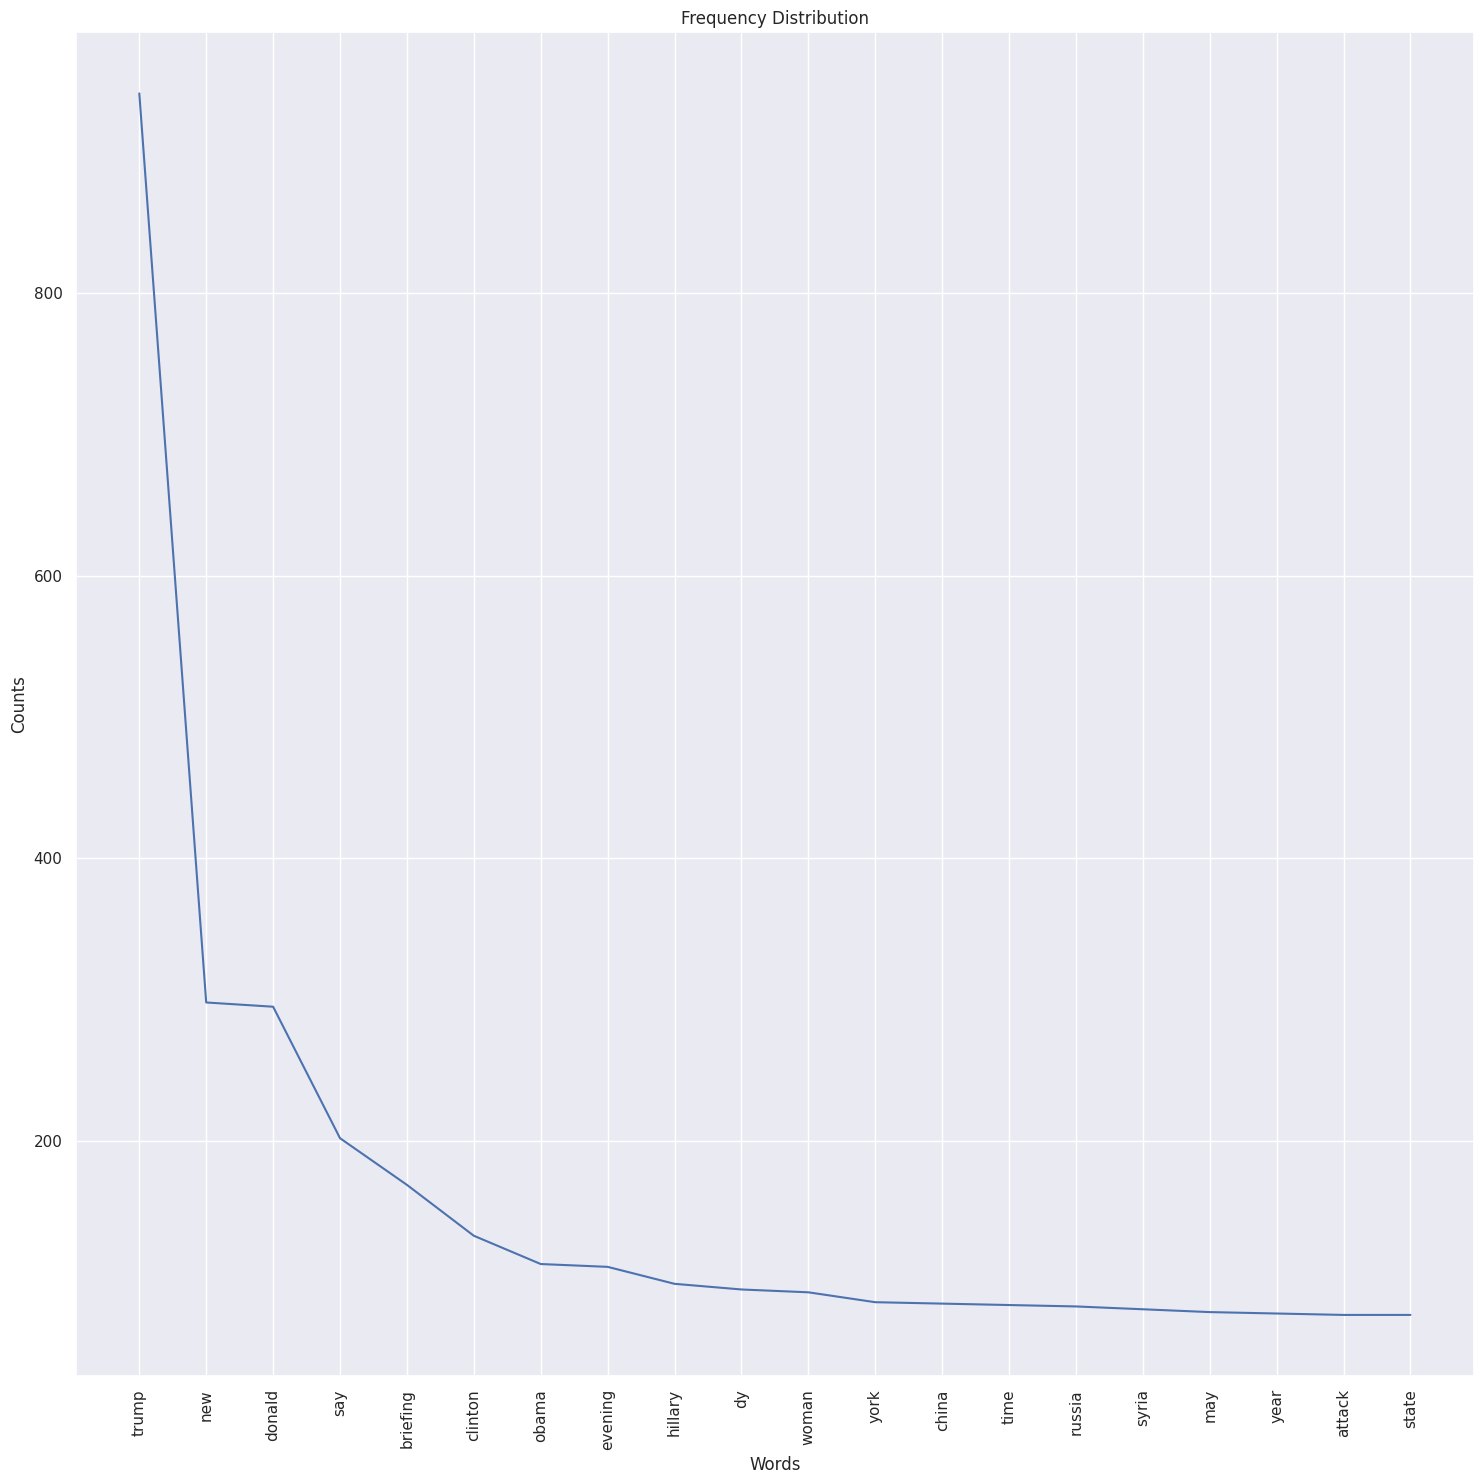

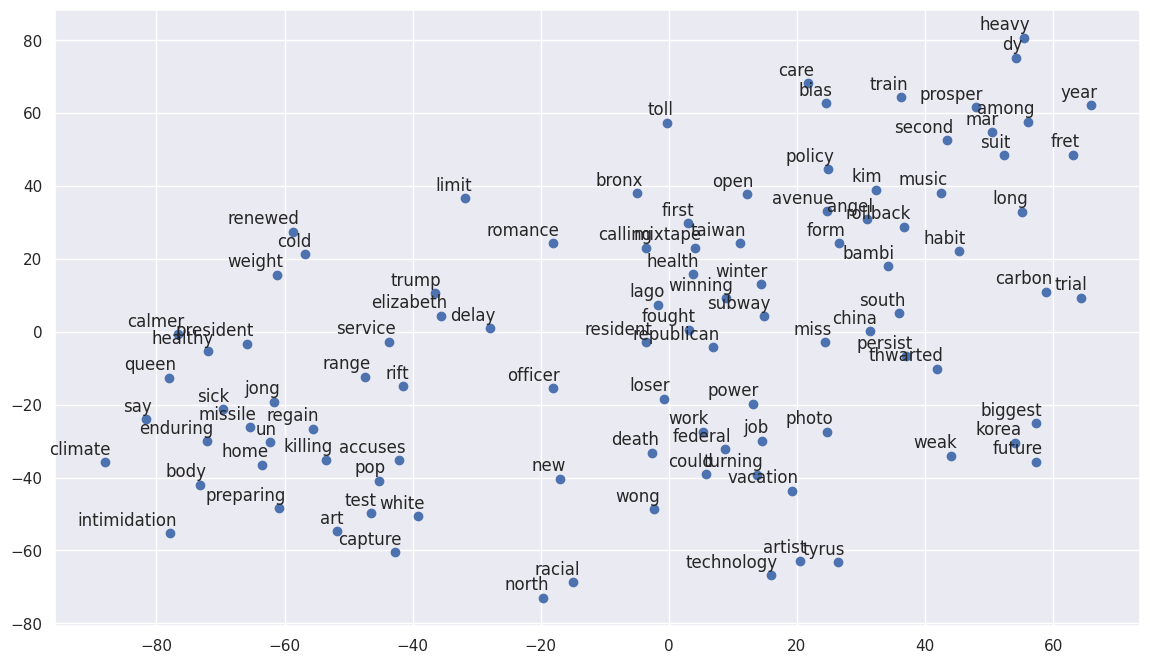

In [ ]:
train_skip(title_tt[:5000])

In [ ]:
'''
Example output for word similarities:

{'death': ['crutcher', 'madaya', 'charleston', 'earthquake', 'brutal', 'vicious', 'jumping', 'family', 'orleans', 'quake'],
'life': ['acknowledges', 'mold', 'gentrifying', 'searching', 'genital', 'dilemma', 'tory', 'primarily', 'dreamless', 'femme'],
'good': ['eternal', 'conservatism', 'way', 'biopic', 'hammer', 'rory', 'filter', 'fracturing', 'critique', 'lotto'],
'bad': ['typical', 'jonbenét', 'kanté', 'higgs', 'showering', 'refreeze', 'nader', 'bang', 'lb', 'joanne'],
'man': ['allegedly', 'jaffa', 'tulsa', 'hyena', 'skydiver', 'trash', 'bangalore', 'bystander', 'stepson', 'suspect'],
'woman': ['gym', 'microbeads', 'slims', 'bam', 'tit', 'punched', 'picasso', 'probe', 'oppresses', 'unconscious'],
'happy': ['cher', 'deadpool', 'mcqueen', 'wonderland', 'ghostbusters', 'tribute', 'shortsighted', 'lawrence', 'television', 'origin'],
'unhappy': ['reconsider', 'corzine', 'caving', 'smacking', 'unmitigated', 'disparate', 'wiping', 'secy', 'warmed', 'b—and'],
'obama': ['barack', 'shifted', 'policy', 'attend', 'grassley', 'rousey', 'administration', 'hiroshima', 'stayed', 'obamatrade'],
'trump': ['predictor', 'nationalism', 'homecoming', 'gasoline', 'mph', 'airstream', 'chameleon', 'remix', 'hospitalized', 'catchy'],
'book': ['siriusxm', 'album', 'retirement', 'mann', 'board', 'walton', 'oscarssowhite', 'faculty', 'co', 'adelson'],
'school': ['student', 'satanic', 'scapegoat', 'disability', 'yale', 'teacher', 'campus', 'quadruplet', 'twelve', 'tiffany'],
'apple': ['iphone', 'revenue', 'hindering', 'software', 'earbuds', 'qualcomm', 'bolster', 'oracle', 'workforce', 'wireless'],
'movie': ['batman', 'trailer', 'dyke', 'composer', 'creative', 'yuja', 'comic', 'song', 'superheroes', 'wbgo'],
'university': ['campus', 'professor', 'satanic', 'satanist', 'student', 'abuse', 'glorification', 'retweets', 'sprayed', 'mistakenly'],
'london': ['terror', 'swimwear', 'collude', 'kubrick', 'masood', 'vile', 'relentless', 'cleaver', 'transgender', 'heathrow'],
'russia': ['russian', 'ukraine', 'sanction', 'ceasefire', 'spy', 'bashar', 'treaty', 'picking', 'installed', 'missile'],
'army': ['civilian', 'ite', 'fighter', 'seal', 'navy', 'tribal', 'warplane', 'squadron', 'shi', 'lumber'],
'feminism': ['ghostbusters', 'thrilling', 'wright', 'winslet', 'rushdie', 'rihanna', 'segregationist', 'reinvigorated', 'poser', 'kung'],
'girl': ['boko', 'boy', 'schoolgirl', 'haram', 'nigerian', 'parking', 'chibok', 'cameroon', 'reunited', 'eco'],
'boy': ['mother', 'stripper', 'girl', 'pirate', 'sportswriter', 'tribeca', 'ankle', 'hopeful', 'gorilla', 'parent']}

'''

"\nExample output for word similarities:\n\n{'death': ['crutcher', 'madaya', 'charleston', 'earthquake', 'brutal', 'vicious', 'jumping', 'family', 'orleans', 'quake'], \n'life': ['acknowledges', 'mold', 'gentrifying', 'searching', 'genital', 'dilemma', 'tory', 'primarily', 'dreamless', 'femme'], \n'good': ['eternal', 'conservatism', 'way', 'biopic', 'hammer', 'rory', 'filter', 'fracturing', 'critique', 'lotto'], \n'bad': ['typical', 'jonbenét', 'kanté', 'higgs', 'showering', 'refreeze', 'nader', 'bang', 'lb', 'joanne'], \n'man': ['allegedly', 'jaffa', 'tulsa', 'hyena', 'skydiver', 'trash', 'bangalore', 'bystander', 'stepson', 'suspect'], \n'woman': ['gym', 'microbeads', 'slims', 'bam', 'tit', 'punched', 'picasso', 'probe', 'oppresses', 'unconscious'], \n'happy': ['cher', 'deadpool', 'mcqueen', 'wonderland', 'ghostbusters', 'tribute', 'shortsighted', 'lawrence', 'television', 'origin'], \n'unhappy': ['reconsider', 'corzine', 'caving', 'smacking', 'unmitigated', 'disparate', 'wiping', 's